
# Hollow Glass Ring in Air

N1 in Bird

In [1]:
import numpy as np

from fiberamp.fiber.microstruct.bragg import BraggScalar, Bragg
from fiberamp.fiber.microstruct.bragg import plotlogf
from ngsolve.webgui import Draw
from ngsolve import CF
from scipy.optimize import newton
from scipy.linalg import null_space

importing NGSolve-6.2.2203-56-g47f483033


In [5]:
n_air = 1
n_glass = 1.44

ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_air]

ts = [5e-05, 1e-5, 5e-05]

mats = ['air', 'glass', 'air']

maxhs = [.1,.01, .1]
wl = 1.2e-06
scale = ts[0]

In [6]:
A = BraggScalar(ts=ts, mats=mats, ns=ns, maxhs=maxhs, wl=wl, scale=scale)


In [7]:
Draw(A.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

In [8]:
k_low = A.k0 * A.ns[0] * A.scale
k_high = A.k0 * A.ns[1] * A.scale
k_low, k_high

(261.79938779914943, 376.9911184307752)

In [55]:
outer = 'h2'
Ktype = 'kappa'
nu = 0

<IPython.core.display.Javascript object>


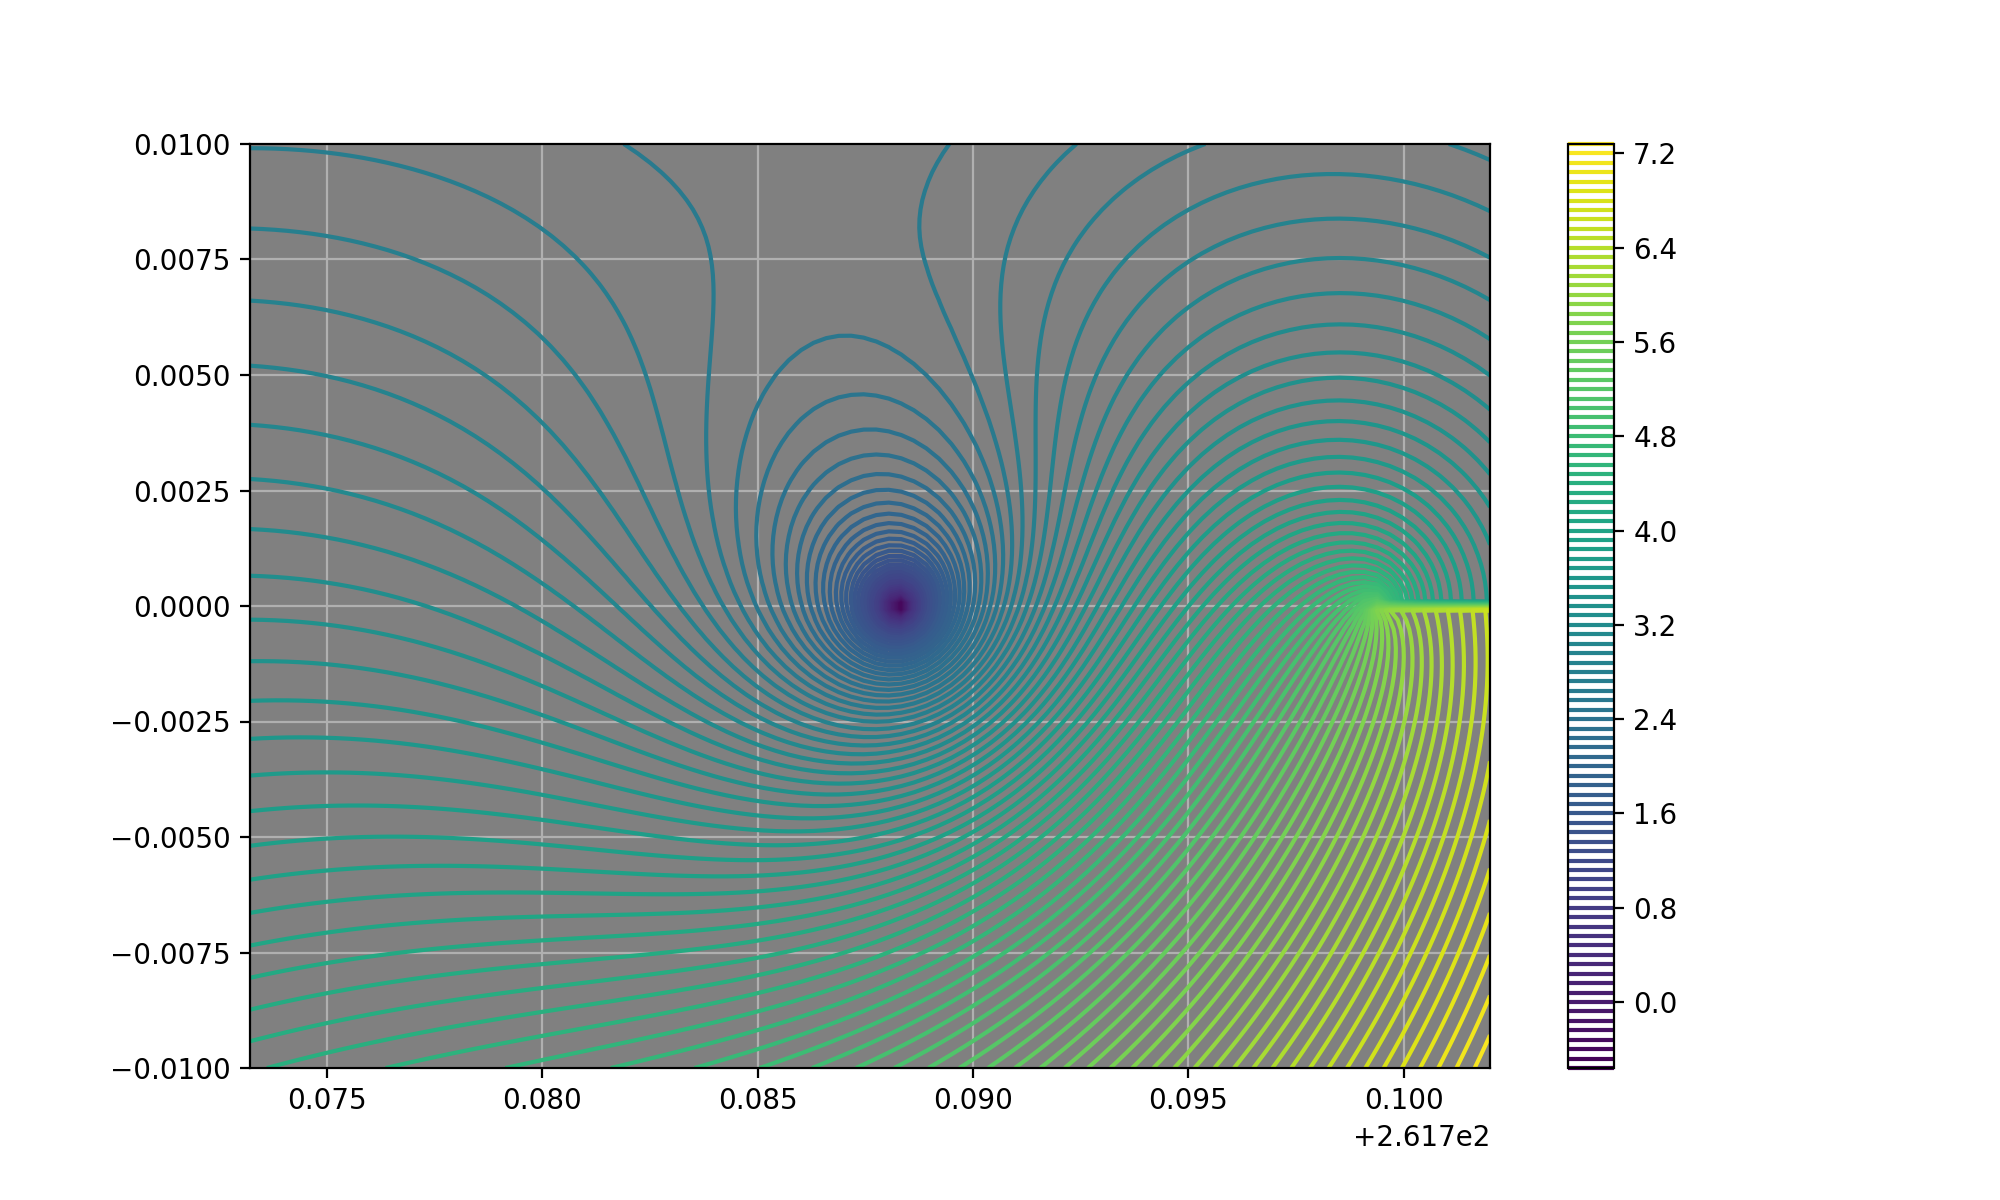

In [56]:
plotlogf(A.determinant,.9999*k_low,1.00001*k_low, -.01,.01, nu, outer, Ktype,
         iref=100, rref=100, levels=100, figsize=(10,6))

In [57]:
guess = np.array(.99995*k_low)

beta1 = newton(A.determinant, guess, args=(nu, outer, Ktype), tol = 1e-15)

print("Scaled beta: ", beta1, ". Residual of determinant: ", abs(A.determinant(beta1, nu, outer, Ktype)))


Scaled beta:  (261.78827028314817-1.317826525351006e-06j) . Residual of determinant:  2.3662079202674337e-10


# Bragg Scalar Function

In [58]:
U = A.all_fields(beta1, nu, outer, Ktype)

In [59]:
Draw(1e1*U, A.mesh, min=-3, max=10)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

### 1D

In [53]:
u = A.fields_matplot(beta1, nu, outer, Ktype)

<IPython.core.display.Javascript object>


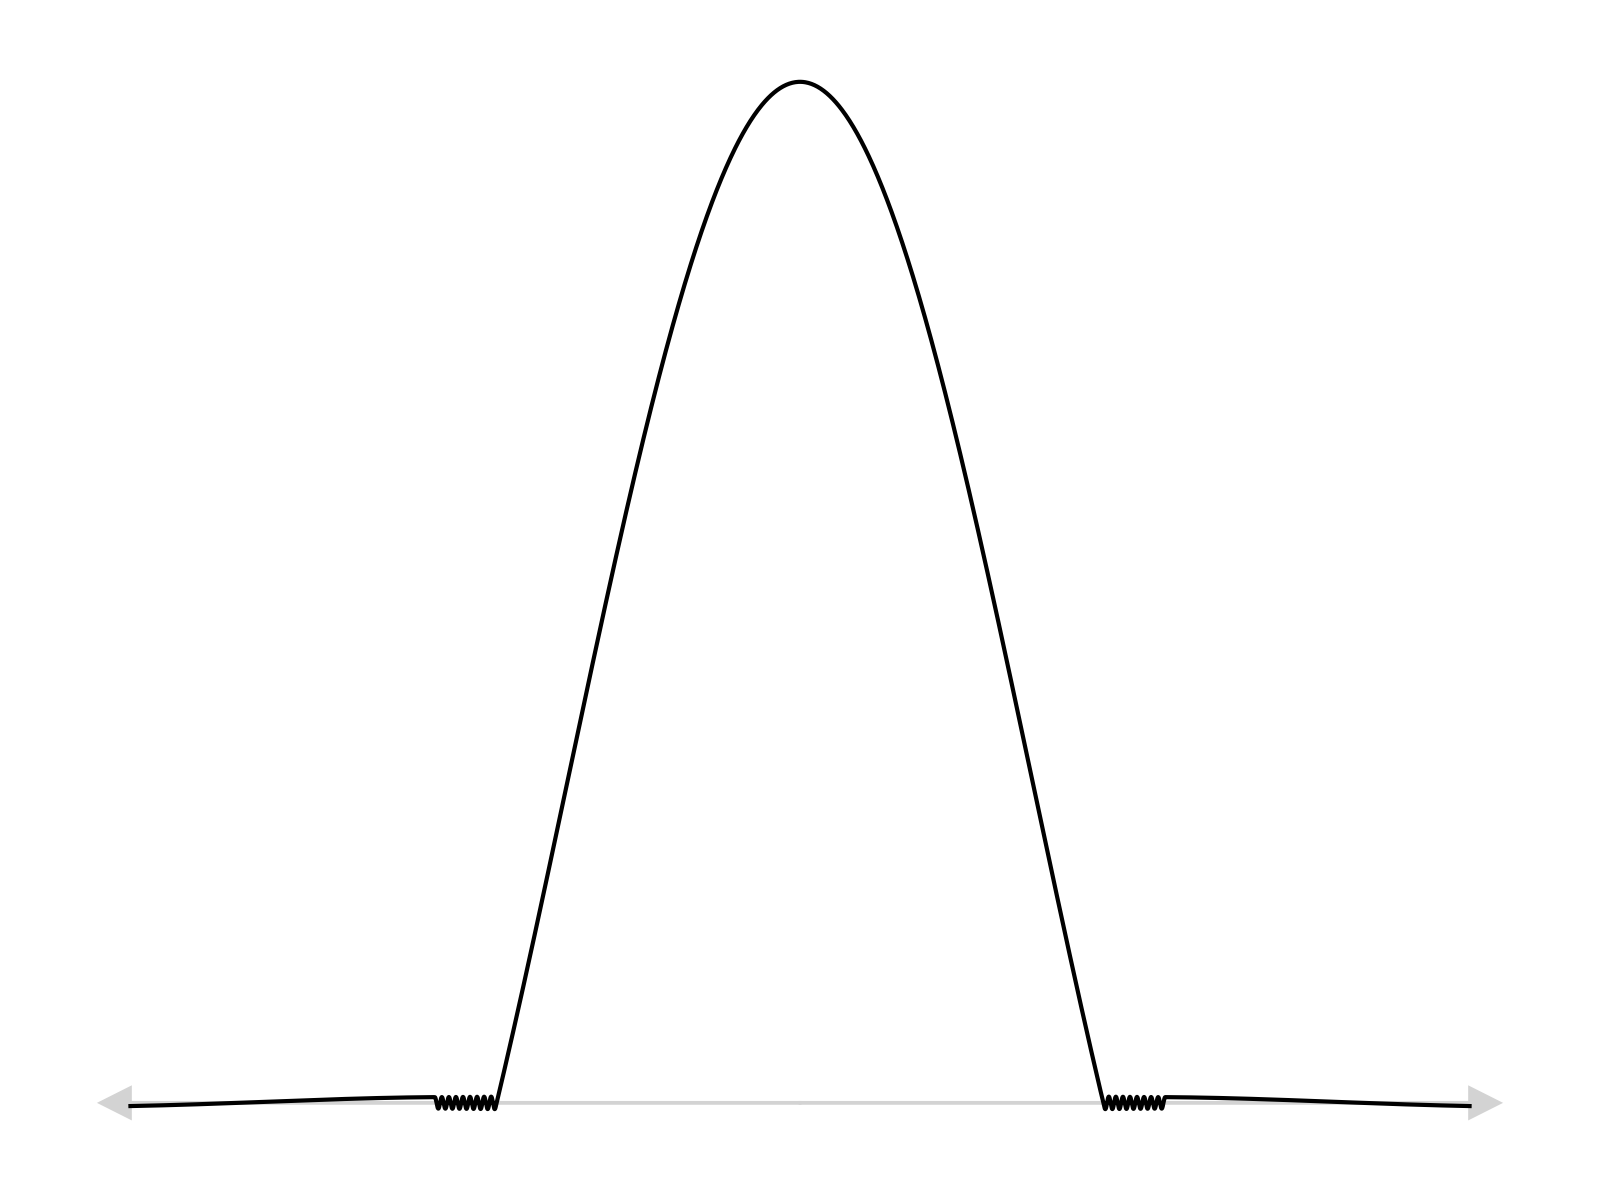

In [54]:
%matplotlib notebook
fig, ax = A.plot1D(u['Ez_rad'], double_r=True, rlist=[400,10000,400], nu=nu, maxscale=True,
                  linewidth=1.5, color='k')
Rhos = A.rhos/A.scale

ax.arrow(0,0, Rhos[-1], 0, color='lightgray', width=.001, 
         head_width=.03, head_length=.1)
ax.arrow(0,0, -Rhos[-1], 0, color='lightgray', width=.001, 
         head_width=.03, head_length=.1)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
m, M = ax.get_ylim()
# for r in Rhos:
#     ax.plot([r,r], [m, M], 'orange', linewidth=1.2, linestyle=':')
#     ax.plot([-r,-r], [m, M], 'orange', linewidth=1.2, linestyle=':')
ax.set_xlabel('\nDistance from Fiber Center')
fig.savefig('/home/pv/papers/outer_materials/figures/images/jpgs/1dlong.jpg')

# Numerical

In [18]:
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_air,  lambda x:n_air]

ts = [5e-05, 1e-5, 2e-05, 2e-05]

mats = ['air', 'glass', 'air', 'Outer']

maxhs = [.1,.01, .08, .1]
wl=1.2e-06
scale = ts[0]
B = Bragg(ts=ts, mats=mats, ns=ns, maxhs=maxhs, wl=wl, scale=scale)


ModeSolver: Checking if mesh has required regions
Mesh has  27788  elements,  13924  points,  and  41711  edges.


In [19]:
Draw(B.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

In [20]:
Z2 = B.sqrZfrom(beta1/A.scale)
Z = Z2**.5
Z

(2.4126736594918357+0.000142991376098823j)

In [21]:
center = Z
radius = 0.1

p = 1
z, y, yl, beta, P, _ = B.leakymode(p,nspan=4,npts=4,
                                    rad=radius,
                                    ctr=center,
#                                     rhoinv=.9,
#                                     quadrule='ellipse_trapez_shift',
                                    alpha=5,
                                    niterations=5, nrestarts=0)

ModeSolver.leakymode called on object with these settings:
Set freq-dependent PML with p= 1  alpha= 5 and thickness=0.400

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.1, Center=2.41267+0.000142991j
SpectralProjNGPoly: Checking if A[d] is nonzero & Hermitian.
SpectralProjNG: Checking if inverse.H works for umfpack
SpectralProjNGPoly: Computing resolvents along the contour using
                    inverse type umfpack (installed default umfpack)
SpectralProjNGPoly: Factorizing 13924x13924 system at z =  +2.483 +0.071j
SpectralProjNGPoly: Factorizing 13924x13924 system at z =  +2.342 +0.071j
SpectralProjNGPoly: Factorizing 13924x13924 system at z =  +2.342 -0.071j
SpectralProjNGPoly: Factorizing 13924x13924 system at z =  +2.483 -0.071j

=========== Starting FEAST iterations ===========
Trying with 4 vectors:

 ITERATION 1 with 4 vectors and 4 left vectors
   During kernel cleaning abs(g):
   [5.7e+02 2.1e-02 2.3e-08 1.9e-08]
   Re

In [22]:
for f in y:
    Draw(1e3*f, B.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

# Resonant mode ?

Would be good to do the wavelength study on this and see if it still has spikes

In [ ]:
# Formula for loss spikes from article

ms = np.arange(11,15,1)

n1 = A.ns[0]  # Inner (core) index
n2 = A.ns[1]  # Cladding index

d = 15*2/3*1e-6

ls = (2 * n1 * d / ms * ((n2/n1)**2 - 1)**.5)  # when n2 depends on ls, need solver
ls

In [ ]:
wl_res= 1.592e-06

In [ ]:
n_air = 1.00027717
n_glass = 1.4388164768221814

ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_air]

ts = [4.0775e-05, 1e-5, 4.0775e-05]

mats = ['air', 'glass', 'air']

maxhs = [.1,.015, .1]

In [ ]:
B = BraggExact(ts=ts, mats=mats, ns=ns, maxhs=maxhs, wl=wl_res)



In [ ]:
k_low = B.k0 * B.ns[0] * B.scale
k_low

In [ ]:
outer = 'h2'
nu = 1

In [ ]:
plotlogf(B.determinant, .995*k_low, 1.001*k_low, -.1,.1, nu, outer,
         iref=100, rref=100, levels=100)

In [ ]:
guess = np.array(.9999 * k_low)

beta1 = newton(B.determinant, guess, args=(nu, outer), tol = 1e-15)

print("Scaled beta: ", beta1, ". Residual of determinant: ", abs(B.determinant(beta1, nu, outer)))


# Bragg Exact Fields

In [ ]:
FsB = B.all_fields(beta1, nu, outer)

### Electric

In [ ]:
Draw(FsB['Ez'], B.mesh)

In [ ]:
fsB = B.fields_matplot(beta1, nu, outer)

In [ ]:
%matplotlib notebook
figsize=(12,6)
fig, ax = B.plot1D(fsB['Sz_rad'], double_r=True, rlist=[400,1000,400], nu=nu, 
                   part='norm', maxscale=True, figsize=figsize, linewidth=.6)
B.add1D_plot(ax, fsA['Sz_rad'], double_r=True,  nu=nu, part='norm', maxscale=True, linewidth=.6)

In [ ]:
Draw(FsB['Sphi'], A.mesh)